In [1]:
%reload_ext autoreload
%autoreload 2

import pickle
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import os
import sys
import datetime
import time
import shutil

sys.path.append('../')
sys.path.append('code/')

from gcarl import gcarl

from dataset import create_Kamitani_dataset
from config import Config_MBM_finetune_cross, merge_needed_cross_config
from sc_mbm.trainer import train_one_epoch_cross, eval_one_epoch_cross
from sc_mbm.utils import save_model_merge_conf
from dataset import create_Kamitani_dataset_distill, create_BOLD5000_dataset_classify, create_THINGS_dataset

from phase2_finetune_CRL import finetune_CRL, eval_one_epoch_CRL
from phase2_finetune_baseline import finetune_baseline
from sc_mbm.mae_for_fmri import MAEforFMRICross
from phase2_finetune_CRL import load_model_image

from nilearn.masking import unmask
from nilearn.plotting import plot_stat_map
from nilearn.image import load_img, index_img
import cortex

plt.rc('figure', dpi=100, figsize=(15,8))
plt.rc('font', size=12, weight=500)
plt.rc('lines', linewidth=2)
plt.rc('axes', facecolor='FAFAFA', edgecolor='C3C3C3', axisbelow=True, grid=True)

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations
INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


#### Things data load

In [2]:
from THINGS_load_data import load_all

selected_ROI = ["glasser-V1", "glasser-V2", "glasser-V3", "glasser-V4", "glasser-LO1", "glasser-LO2", "glasser-LO3", "glasser-VMV1", "glasser-VMV2", "glasser-VMV3", "glasser-PHA1", "glasser-PHA2", "glasser-PHA3"]

full_sets, train_sets, test_sets, labels = load_all(selectedROI=selected_ROI, reload_resnet=False, ratio=0.6)
responses, voxdata, stimdata, images, image_features, semantic_emb, similarity_emb, full_categories = full_sets
res_train, im_train, imf_train, sem_train, simi_train, cat_train = train_sets
res_test, im_test, imf_test, sem_test, simi_test, cat_test = test_sets

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


ROIs selected. Number of ROIs : 13
ROI not found for 0 voxels
Selected 4600 voxels from the original 7668


In [3]:
from thingsmri.dataset import ThingsmriLoader

dl = ThingsmriLoader(
    thingsmri_dir='/home/aip/dufly/Documents/THINGS-CRL/'
)

sub = '01'
o_responses, o_stimdata, o_voxdata = dl.load_responses(sub)

#### Model load

In [2]:
base_path = '/home/aip/dufly/Documents/GOD/results/fmri_finetune_THINGS_sbj_1/02-07-2024-16-13-34/checkpoints_39/'
model_name = 'checkpoint_cross_att_GOD_s_fmriw1.0_imgw1.0_fmar0.75_imar0.75.pth'

model_path, crl_path = base_path + model_name, base_path + 'checkpoint_CRL.pth'

In [3]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

ckpt = torch.load(model_path, map_location='cpu')
config_pretrain = ckpt['config']
config = Config_MBM_finetune_cross()

#sd = torch.load(config.pretrain_mbm_path, map_location='cpu')
#config_pretrain = sd['config']

model_image, model_image_config, image_feature_extractor = load_model_image(config)
model_image.to(device)

num_voxels = (ckpt['model']['pos_embed'].shape[1] - 1)* config_pretrain.patch_size

model = MAEforFMRICross(num_voxels=num_voxels, patch_size=config_pretrain.patch_size, embed_dim=config_pretrain.embed_dim,
                        decoder_embed_dim=config_pretrain.decoder_embed_dim, depth=config_pretrain.depth, 
                        num_heads=config_pretrain.num_heads, decoder_num_heads=config_pretrain.decoder_num_heads, 
                        mlp_ratio=config_pretrain.mlp_ratio, focus_range=None, use_nature_img_loss=False, 
                        do_cross_attention=False, cross_encoder_config=model_image_config,
                        decoder_depth=config.fmri_decoder_layers)

model.load_state_dict(ckpt['model'])
model.to(device)
model.eval()

/home/aip/dufly/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/aip/dufly/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


MAEforFMRICross(
  (patch_embed): PatchEmbed1D(
    (proj): Conv1d(1, 1024, kernel_size=(16,), stride=(16,))
  )
  (blocks): ModuleList(
    (0-23): 24 x Block(
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=1024, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=1024, out_features=1024, bias=True)
        (drop2): Dropout(p=0.0, inplac

In [4]:
crl_model = torch.load(crl_path, map_location='cpu')

In [5]:
w0 = crl_model['model_crl']['w0']
w1 = crl_model['model_crl']['w1']

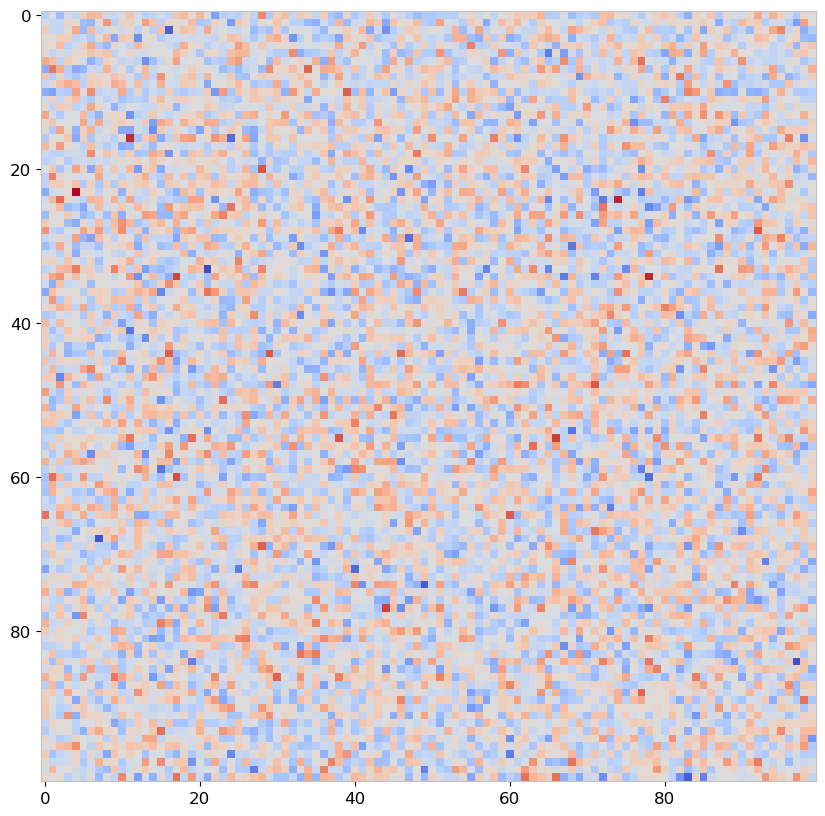

In [6]:
# plot both

plt.figure(figsize=(10, 10))
plt.grid(False)
plt.imshow(w0.detach().cpu().numpy()[:100,:100], aspect='auto', cmap='coolwarm')
plt.show()

In [9]:
emb = w0.detach().cpu().numpy()[0,:]

In [10]:
# generate the output fro; the decoder when the encoding is patches of [1,0,0,0,0,...]

embed = torch.zeros(1, 292, config_pretrain.embed_dim)

# randomly select 30 dims to set to 1
for i in range(292):
    embed[0, i, 0] = 1

embed = embed.to(device)

output = model.free_decoder(embed)

x torch.Size([1, 292, 512])
num_patches 292
x torch.Size([1, 292, 512])
x torch.Size([1, 292, 512])
x torch.Size([1, 292, 512])


In [11]:
embed.shape

torch.Size([1, 292, 1024])

In [12]:
# unpatchify the output

unpatch = model.unpatchify(output)
print(unpatch.shape)

torch.Size([1, 1, 4656])


#### Encode-decode tests

In [260]:
# use the frst example of res_train as input to the modelncoder

res_train[5:6].shape

fmri_input = np.pad(res_train[0:1], ((0,0), (0, num_voxels - res_train[0:1].shape[-1])), 'wrap')

In [266]:
encoding = model.forward_encoder(torch.tensor(fmri_input).unsqueeze(1).float().to(device), mask_ratio=0)

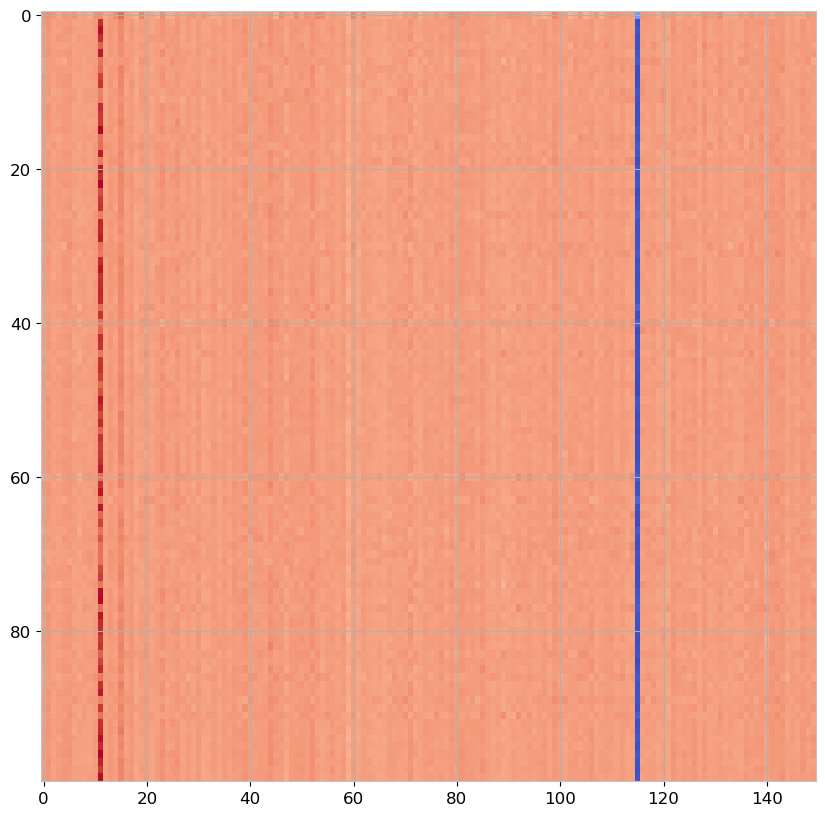

In [267]:
plt.figure(figsize=(10, 10))
plt.imshow(encoding[0].detach().cpu().numpy().reshape(292, 1024)[:100, 300:450], aspect='auto', cmap='coolwarm')
plt.show()

In [268]:
output_from_original = model.free_decoder(encoding[0])

x torch.Size([1, 292, 512])
num_patches 292
x torch.Size([1, 292, 512])
x torch.Size([1, 292, 512])
x torch.Size([1, 292, 512])


In [269]:
output_from_original = model.forward_decoder(encoding[0], encoding[2])

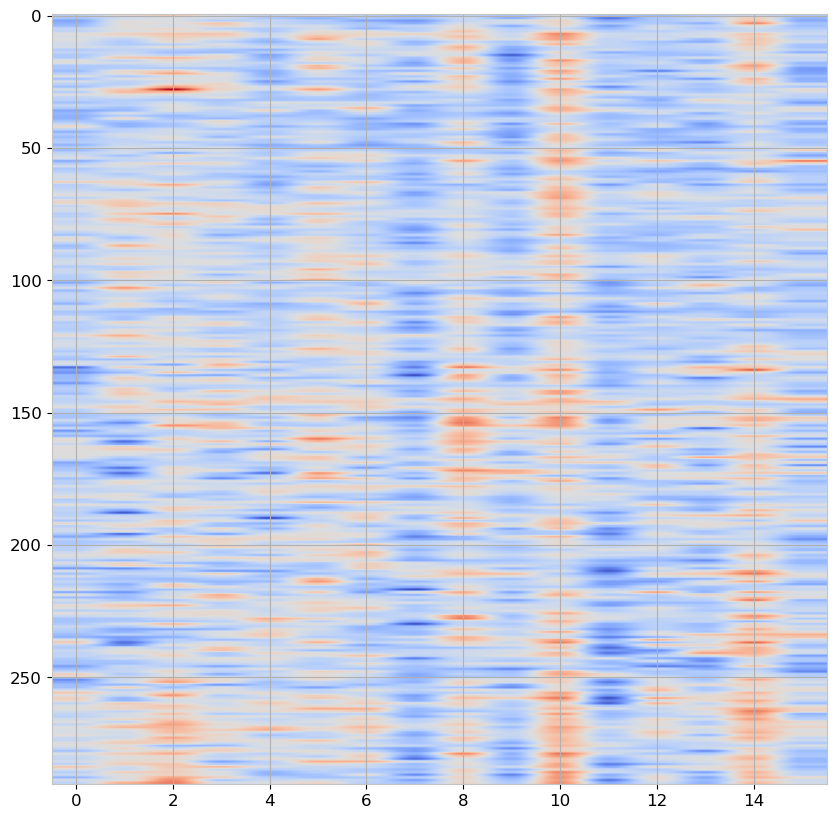

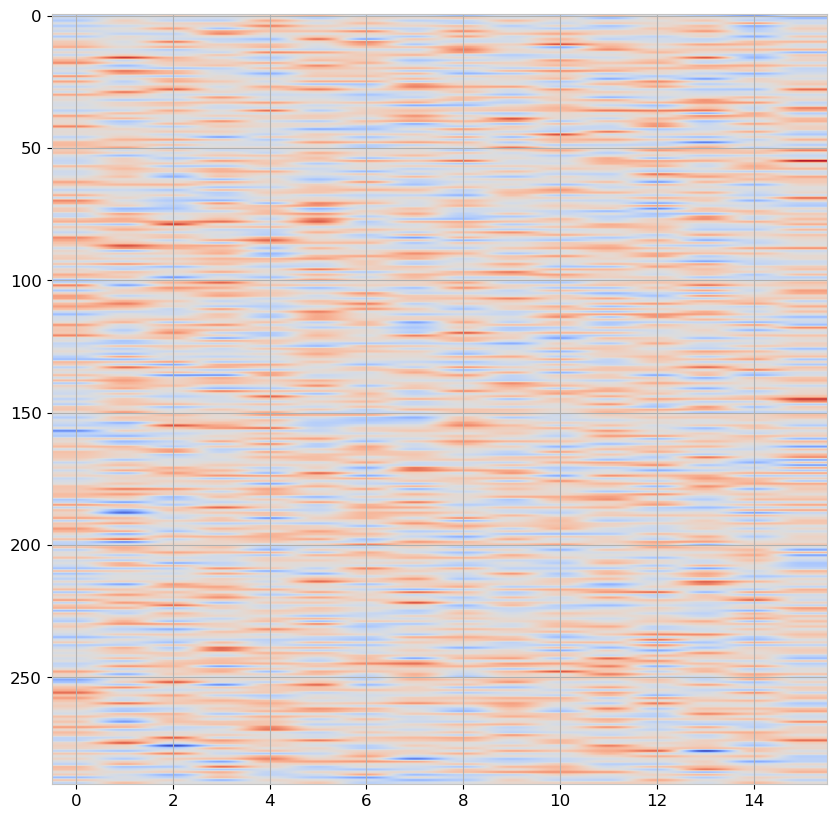

In [270]:
# visualize the output

plt.figure(figsize=(10, 10))
plt.imshow(output_from_original.detach().cpu().numpy().reshape(291, 16), aspect='auto', cmap='coolwarm')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(fmri_input.reshape(291,16), aspect='auto', cmap='coolwarm')

In [271]:
fmri_input = torch.tensor(fmri_input).unsqueeze(1).float().to(device)

In [278]:
# check if the autoencoder is working

loss, pred, mask = model.forward(fmri_input, mask_ratio=0.75)
loss

tensor(0.0435, device='cuda:2', grad_fn=<DivBackward0>)

In [279]:
target = model.patchify(fmri_input)

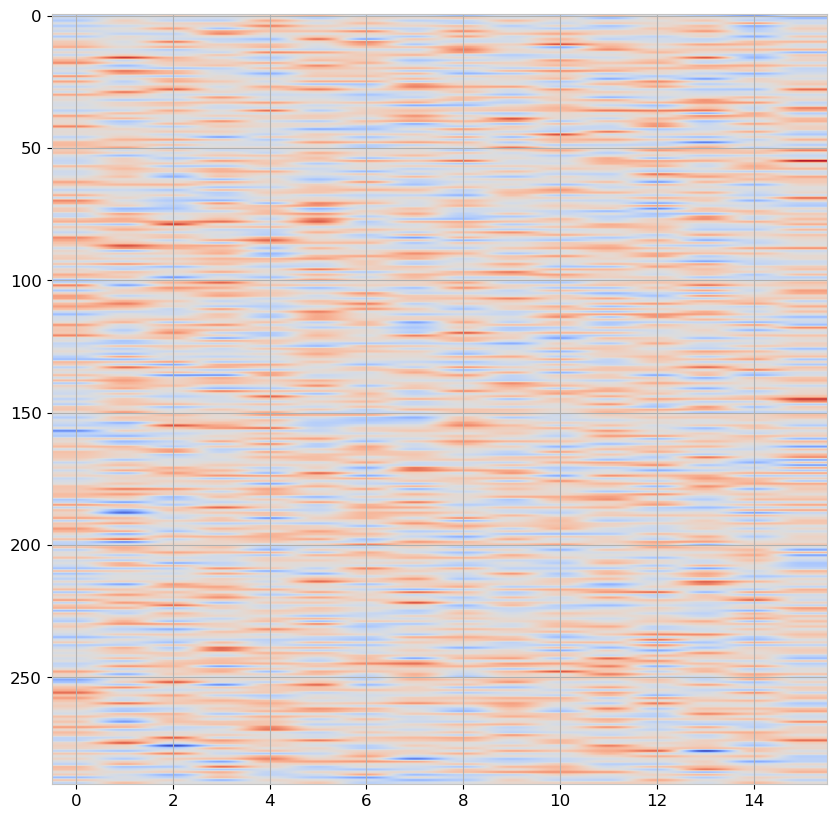

In [280]:
plt.figure(figsize=(10, 10))
plt.imshow(target.detach().cpu().numpy().reshape(291, 16), aspect='auto', cmap='coolwarm')
plt.show()

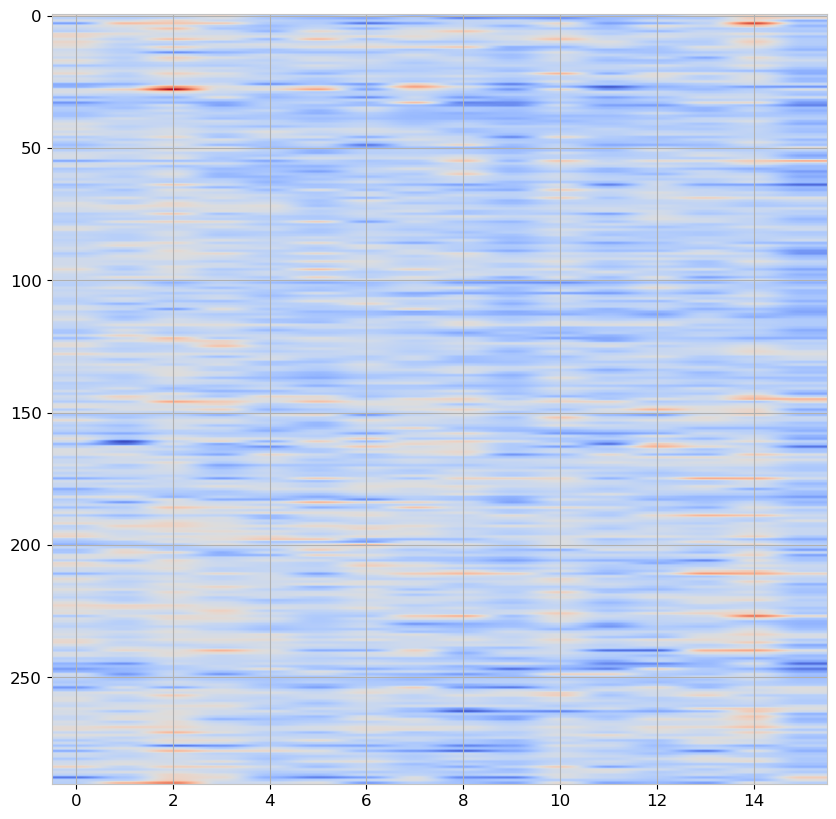

In [281]:
plt.figure(figsize=(10, 10))
plt.imshow(pred.detach().cpu().numpy().reshape(291, 16), aspect='auto', cmap='coolwarm')
plt.show()

In [282]:
cor = torch.mean(torch.tensor([torch.corrcoef(torch.cat([p, s],axis=0))[0,1] for p, s in zip(pred, target)])).item()
cor

0.5753718018531799

In [283]:
pred_un, target_un = model.unpatchify(pred), model.unpatchify(target)
cor = torch.mean(torch.tensor([torch.corrcoef(torch.cat([p, s],axis=0))[0,1] for p, s in zip(pred_un, target_un)])).item()
cor

0.14334583282470703

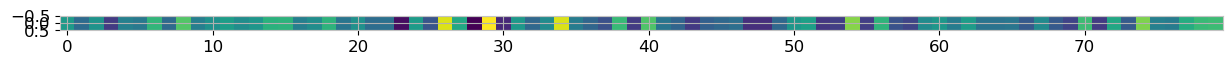

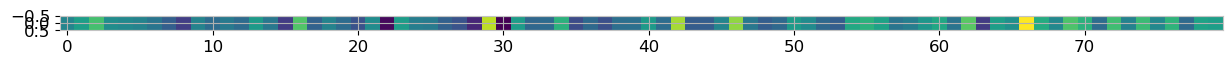

In [291]:
plt.imshow(pred_un.detach().cpu().numpy()[0,0:1,120:200])
plt.show()
plt.imshow(target_un.detach().cpu().numpy()[0,0:1,120:200])

#### Brain display

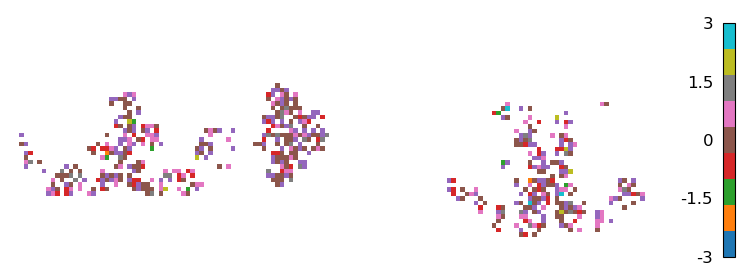

In [ ]:
brainmask = dl.get_brainmask('01')
roimask = o_voxdata[selected_ROI].sum(axis=1).values.astype(bool)
# select rows with indices in responses.index
voxelmask = o_voxdata.index.isin(responses.index)

# set a different value for each ROI
results = np.zeros(voxdata.shape[0])
results = output.detach().cpu().numpy().reshape(4672)[:4600]

#for i, roi in enumerate(selected_ROI):
#    m = voxdata[roi].values.astype(bool)
#    results[m] = i*3-10

# First, create a placeholder array that has the correct shape
nvoxels_brain = 211339
results_wholebrain = np.zeros(nvoxels_brain)

# populate the whole brain array with the results from the ROI
results_wholebrain[voxelmask] = results

# we can use nilearn's unmask function to create a 3D image from the spatially unstructured array
results_img = unmask(results_wholebrain, brainmask)

g = plot_stat_map(results_img, bg_img=None, cmap='tab10', draw_cross=False, annotate=False)

results_img.to_filename(f'results.nii.gz')

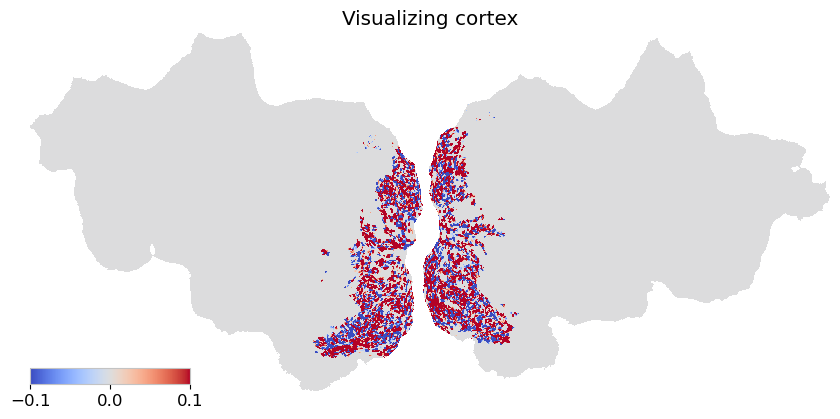

In [ ]:
results_data = np.swapaxes(load_img('results.nii.gz').get_fdata(), 0, -1)
vol_data = cortex.Volume(results_data, 'S1', 'align_auto', cmap='coolwarm')

fig = plt.figure(figsize=(8,4))
cortex.quickshow(
    vol_data, pixelwise=True, nanmean=True, colorbar_location='left', with_rois=False, fig=fig, cmap='tab10'
)
plt.title(f'Visualizing cortex')
plt.show()